Check the blog post associated with this notebook here:
* https://andresberejnoi.com/how-to-implement-backpropagation-with-numpy/



#### Package And Library Versions
* Python : 3.10.9 | packaged by conda-forge | (main, Jan 11 2023, 15:15:40) [MSC v.1916 64 bit (AMD64)]
* Numpy  : 1.23.5
* Jupyter (command 'jupyter --version' in the terminal):
    - Selected Jupyter core packages...
    - IPython          : 8.12.0
    - ipykernel        : 6.15.0
    - ipywidgets       : not installed
    - jupyter_client   : 8.2.0
    - jupyter_core     : 5.3.0
    - traitlets        : 5.9.0
    

##### Optional Packages For Plots At The End
* Pandas : 1.5.3
* Matplotlib : 3.7.1

In [116]:
import numpy as np

In [117]:
# define some activation and error functions
def tanh(x, derivative=False):
    """Implements the hyperbolic tangent function element wise over an array x.

    Parameters
    ----------
    x : numpy array
        This array contains arguments for the hyperbolic tangent function.
    derivative : bool
        Indicates whether to use the hyperbolic tangent function or its derivative.

    Returns
    -------
    numpy array
        An array of equal shape to `x`.
    """

    if derivative:
        tanh_not_derivative = tanh(x)
        return 1.0 - tanh_not_derivative**2
        #return 1.0 - x**2
    else:
        return np.tanh(x)

def relu(x, derivative=False):
    if derivative:
        return 1 * (x > 0)  #returns 1 for any x > 0, and 0 otherwise
    
    return np.maximum(0, x)


def mean_squared_error(target_output, actual_output, derivative=False):
    try:
        assert(target_output.shape == actual_output.shape)
    except AssertionError:
        print(f"Shape of target vector: {target_output.shape} does not match shape of actual vector: {actual_output.shape}")
        raise
    
    if derivative:
        error = (actual_output - target_output)
    
    else:
        error = np.sum(0.5 * np.sum((target_output-actual_output)**2, axis=1, keepdims=True))  #the outer np.sum simply returns a scalar, instead of an numpy array
        
    return error

In [179]:
class NeuralNet(object):
    RNG = np.random.default_rng()

    def __init__(self, 
                 topology:list[int] = [], 
                 learning_rate = 0.01,
                 momentum      = 0.1,
                 hidden_activation_func=relu, 
                 output_activation_func=tanh,
                 init_method='random'):
        
        self.topology    = topology
        self.weight_mats = []
        self.bias_mats   = []   #will hold the weights for the bias nodes

        self.learning_rate = learning_rate
        self.momentum      = momentum

        self.hidden_activation = hidden_activation_func
        self.output_activation = output_activation_func


        self._init_weights_and_biases(init_method)
        self.size             = len(self.weight_mats)
        self.netIns           = [None] * self.size    #store the inputs to each layer
        self.netOuts          = [None] * self.size    #store the activations from each layer
        #self.stored_gradients = [None] * self.size
        self.last_change = [np.zeros(mat.shape) for mat in self.weight_mats]

        #-- create similar lists to store gradients for the bias weigths
        #self.stored_bias_gradients = [np.zeros(mat.shape) for mat in self.bias_mats]
        self.last_bias_change      = [np.zeros(mat.shape) for mat in self.bias_mats]

    def _init_weights_and_biases(self, method='random'):
        #-- decide which initialization method to use. I added some of the popular ones
        if method.lower() == 'random':
            _init_func = lambda num_rows, num_cols: self.RNG.random(size=(num_rows, num_cols))

        elif method.lower() == 'xavier':
            _init_func = self._xavier_weight_initialization

        else:
            print(f"\t-> initialization method {method} not recognized. Defaulting to 'random'")
            _init_func = lambda num_rows, num_cols: self.RNG.random(size=(num_rows, num_cols))

        #-- set up matrices
        if len(self.topology) > 1:
            j = 1
            for i in range(len(self.topology)-1):
                num_rows = self.topology[i]
                num_cols = self.topology[j]

                mat         = _init_func(num_rows, num_cols)  #the +1 accounts for the bias weights
                bias_vector = _init_func(1, num_cols) 

                self.weight_mats.append(mat)
                self.bias_mats.append(bias_vector)

                j += 1


    def _xavier_weight_initialization(self, num_rows, num_cols):
        '''A type of weight initialization that seems to be tailored to sigmoidal activation functions.
        Here is a reference: https://machinelearningmastery.com/weight-initialization-for-deep-learning-neural-networks/'''
        num_inputs = self.topology[0]

        lower_bound = -1 / np.sqrt(num_inputs)
        upper_bound = 1 / np.sqrt(num_inputs)

        mat = self.RNG.uniform(lower_bound, upper_bound, (num_rows, num_cols))
        return mat

    @property
    def shape(self):
        return tuple(self.topology)
    
    @property
    def n_trainable_params(self):
        n_params = 0 
        for weight_mat, bias_mat in zip(self.weight_mats, self.bias_mats):
            n_params += weight_mat.size + bias_mat.size

        return n_params
        


    def feedforward(self, input_vector):

        self.netIns.clear()
        self.netOuts.clear()

        I = input_vector  #rename vector to match typical nomenclature

        for idx, W in enumerate(self.weight_mats):
            
            bias_vector = self.bias_mats[idx]

            self.netOuts.append(I)    #storing activations from the last layer
            I = np.dot(I, W) + bias_vector
            self.netIns.append(I)       #storing the inputs to the current layer
            
            #-- apply activation function
            if idx == len(self.weight_mats) - 1:
                out_vector = self.output_activation(I)  #output layer
            else:
                I          = self.hidden_activation(I)  #hidden layers
            
        return out_vector
    

    def _gradient_descent(self, layer_idx, gradient_mat, bias_gradient):
        
        #-- Calculate the changes in weights for all nodes and bias weights
        delta_weight = (self.momentum * self.last_change[layer_idx]) - (self.learning_rate * gradient_mat[layer_idx])
        
        delta_bias_weights =  (self.momentum * self.last_bias_change[layer_idx]) \
                            - (self.learning_rate * bias_gradient)
        
        #-- Update Weights
        self.weight_mats[layer_idx] += delta_weight    #the negative of the gradient is above
        self.bias_mats[layer_idx]   += delta_bias_weights

        #-- Keep track of latest delta weights for next iteration/epoch to compute momentum term
        self.last_change[layer_idx]      = 1 * delta_weight
        self.last_bias_change[layer_idx] = 1 * delta_bias_weights

    def backprop(self, 
                 target,
                 output,
                 error_func,):
        """Backpropagation.

        Parameters
        ----------
        target : numpy array
            Matching targets for each sample in `input_samples`.
        output : numpy array
            Actual output from feedforward propagation. It will be used to check the network's error.
        error_func : function object
            This is the function that computes the error of the epoch and used during backpropagation.
            It must accept parameters as: error_func(target={target numpy array},actual={actual output from network},derivative={boolean to indicate operation mode})
        """

        #Compute gradients and deltas
        for i in range(self.size):
            back_index =self.size-1 -i                  # This will be used for the items to be accessed backwards

            if i == 0:   #final layer
                d_activ = self.output_activation(self.netIns[back_index], derivative=True)
                d_error = error_func(target,output,derivative=True)
                delta = d_error * d_activ   #this should be the hadamard product, I think
                #delta = np.multiply(d_error, d_activ)

                gradient_mat  = np.dot(self.netOuts[back_index].T , delta)
                bias_grad_mat = 1 * delta

                #-- Apply gradient descent
                self._gradient_descent(layer_idx=back_index, gradient_mat=gradient_mat, bias_gradient=bias_grad_mat)

            else:     #hidden layers
                W_trans = self.weight_mats[back_index+1].T        #we use the transpose of the weights in the current layer
                d_activ = self.hidden_activation(self.netIns[back_index],derivative=True)  #δl=((wl+1)Tδl+1)⊙σ′(zl)
                d_error = np.dot(delta, W_trans)
                delta = d_error * d_activ   #this should be the hadamard product, I think
                #delta = np.multiply(d_error, d_activ)

                gradient_mat = np.dot(self.netOuts[back_index].T , delta)
                bias_grad_mat = 1 * delta

                #-- Apply gradient descent
                self._gradient_descent(layer_idx=back_index, gradient_mat=gradient_mat, bias_gradient=bias_grad_mat)


    def train(self, input_set, target_set, epochs=1000, batch_size=0, error_threshold=1E-10, error_func=mean_squared_error, verbose=True):

        if batch_size == 0:     #online training (one sample at a time)
            
            for epoch in range(epochs):
                error = 0

                for i in range(len(input_set)):
                    inputs = input_set[i:i+1]   #slicing it this way makes sure that the resulting numpy array maintains all of its dimensions
                    targets = target_set[i:i+1]

                    error += self._train_helper(inputs, targets, error_func)

                if verbose and (epoch % 20 == 0):
                    self._print_training_info(epoch, epochs, error, error_threshold)

                if error <= error_threshold:
                    print(f"\t-> error {error} is lower than threshold {error_threshold}\n\tStopped at epoch {epoch}")
                    break

        elif batch_size == -1:     #batch training (use full training set)
            
            for epoch in range(epochs):
                error = 0

                inputs  = input_set
                targets = target_set

                error += self._train_helper(inputs, targets, error_func)


                if verbose and (epoch % 20 == 0):
                    self._print_training_info(epoch, epochs, error, error_threshold)
                
                if error <= error_threshold:
                        print(f"\t-> error {error} is lower than threshold {error_threshold}\n\tStopped at epoch {epoch}")
                        break
                
        else:   #handle mini-batches later
            print("\t-> PROBLEM: mini-batches not supported yet. Choose batch_size 0 or -1")

        return error

    def _print_training_info(self, curr_epoch, total_epochs, curr_error, error_threshold):
        text = f"""{'-'*45}\n\t-> training step: :{curr_epoch}/{total_epochs}\n\t\t* current error: {curr_error}, threshold: {error_threshold}\n"""
        print(text)

    def _train_helper(self, input_set, target_set, error_func):
        nnet_output = self.feedforward(input_set)
        error       = error_func(target_set, nnet_output)
        
        self.backprop(target=target_set, output=nnet_output, error_func=error_func,)
        return error

In [119]:
#logic gate inputs (this will be our training set)
inputs  = np.array([[0,0], 
                    [0,1], 
                    [1,0], 
                    [1,1]])

#outputs of different logic gates when given the inputs above
training_targets = {
    'XOR'  : np.array([[0],
                       [1],
                       [1],
                       [0]]),

    'OR'   : np.array([[0],
                       [1],
                       [1],
                       [1]]),

    'AND'  : np.array([[0],
                       [0],
                       [0],
                       [1]]),

    'NAND' : np.array([[1],
                       [1],
                       [1],
                       [0]]),
}

In [120]:
# Create a neural network for the XOR logic gate, so two inputs and one output neuron. 
nnet = NeuralNet([2, 3, 1], hidden_activation_func=relu, output_activation_func=tanh, init_method='random')

nnet.train(inputs, training_targets['NAND'], epochs=1000, batch_size=0)

0.47727461020712086

In [121]:
#-Network parameters
m           = 0.9            #momentum
a           = 0.01           #learning rate
init_method = 'xavier'       #weight initialization method
hidden_f    = tanh           #activation function for hidden layers
output_f    = tanh           #activation function for output layer
epochs      = 1000
batch_size  = 0
e_threshold = 1E-5           #error threshold to stop training

network_topology = [2, 3, 1] #shape of the network and its layers

for gate in training_targets:
    print(f"\n\n{'='*40}\nTraining {gate} gate:\n{'='*40}\n")
    input_data = inputs 
    target_data = training_targets[gate]

    #-- create a new network for each set so they are independent of each other
    nnet = NeuralNet(network_topology, hidden_activation_func=hidden_f, output_activation_func=output_f, init_method=init_method, momentum=m, learning_rate=a)
    error = nnet.train(input_data, target_data, epochs=epochs, error_func=mean_squared_error, batch_size=batch_size, error_threshold=e_threshold)

    # Test different inputs
    for i, sample in enumerate(input_data):
        output = nnet.feedforward(sample)
        sample_error = mean_squared_error(target_data[i:i+1], output)
        print(f"Testing Network:\n\tinput vector    : {sample}\n\toutput vector   : {output}\n\texpected output : {target_data[i]}")
        print(f"\tNetwork error   : {sample_error:.3e}\n")



Training XOR gate:

Testing Network:
	input vector    : [0 0]
	output vector   : [[0.09554581]]
	expected output : [0]
	Network error   : 4.565e-03

Testing Network:
	input vector    : [0 1]
	output vector   : [[0.73796201]]
	expected output : [1]
	Network error   : 3.433e-02

Testing Network:
	input vector    : [1 0]
	output vector   : [[0.75084706]]
	expected output : [1]
	Network error   : 3.104e-02

Testing Network:
	input vector    : [1 1]
	output vector   : [[0.13546534]]
	expected output : [0]
	Network error   : 9.175e-03



Training OR gate:

Testing Network:
	input vector    : [0 0]
	output vector   : [[0.00056594]]
	expected output : [0]
	Network error   : 1.601e-07

Testing Network:
	input vector    : [0 1]
	output vector   : [[0.99146453]]
	expected output : [1]
	Network error   : 3.643e-05

Testing Network:
	input vector    : [1 0]
	output vector   : [[0.98091808]]
	expected output : [1]
	Network error   : 1.821e-04

Testing Network:
	input vector    : [1 1]
	output vect

---
## Plots of Activation Functions
Ignore this section of the notebook. I wanted to create some sample plots to show the shape of the activation functions mentioned in the blog post.

In [122]:
import matplotlib.pyplot as plt
import pandas as pd

In [123]:
x = np.linspace(-5, 5, 100)

In [124]:
x

array([-5.        , -4.8989899 , -4.7979798 , -4.6969697 , -4.5959596 ,
       -4.49494949, -4.39393939, -4.29292929, -4.19191919, -4.09090909,
       -3.98989899, -3.88888889, -3.78787879, -3.68686869, -3.58585859,
       -3.48484848, -3.38383838, -3.28282828, -3.18181818, -3.08080808,
       -2.97979798, -2.87878788, -2.77777778, -2.67676768, -2.57575758,
       -2.47474747, -2.37373737, -2.27272727, -2.17171717, -2.07070707,
       -1.96969697, -1.86868687, -1.76767677, -1.66666667, -1.56565657,
       -1.46464646, -1.36363636, -1.26262626, -1.16161616, -1.06060606,
       -0.95959596, -0.85858586, -0.75757576, -0.65656566, -0.55555556,
       -0.45454545, -0.35353535, -0.25252525, -0.15151515, -0.05050505,
        0.05050505,  0.15151515,  0.25252525,  0.35353535,  0.45454545,
        0.55555556,  0.65656566,  0.75757576,  0.85858586,  0.95959596,
        1.06060606,  1.16161616,  1.26262626,  1.36363636,  1.46464646,
        1.56565657,  1.66666667,  1.76767677,  1.86868687,  1.96

In [125]:
y = np.tanh(x)

In [126]:
df_tanh = pd.DataFrame({
    "x":x,
    "tanh(x)":y
}).set_index('x')
df_tanh

,tanh(x)
x,
-5.00000,-0.999909
-4.89899,-0.999889
-4.79798,-0.999864
-4.69697,-0.999834
-4.59596,-0.999796
...,...
4.59596,0.999796
4.69697,0.999834
4.79798,0.999864


<Axes: title={'center': 'Hyperbolic Tangent Example'}, xlabel='x'>

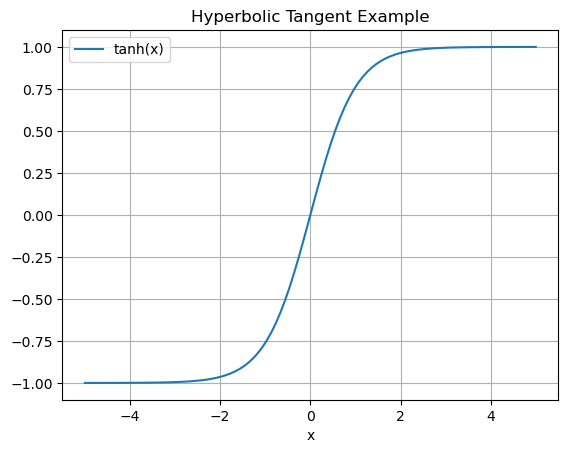

In [127]:
df_tanh.plot(title="Hyperbolic Tangent Example", grid=True)

In [128]:
df_relu = pd.DataFrame({
    'x':x
}).set_index('x')
df_relu

""
x
-5.00000
-4.89899
-4.79798
-4.69697
-4.59596
...
4.59596
4.69697
4.79798


In [129]:
df_relu['relu(x)'] = relu(x)
df_relu

,relu(x)
x,
-5.00000,0.00000
-4.89899,0.00000
-4.79798,0.00000
-4.69697,0.00000
-4.59596,0.00000
...,...
4.59596,4.59596
4.69697,4.69697
4.79798,4.79798


<Axes: title={'center': 'Example of ReLU function'}, xlabel='x'>

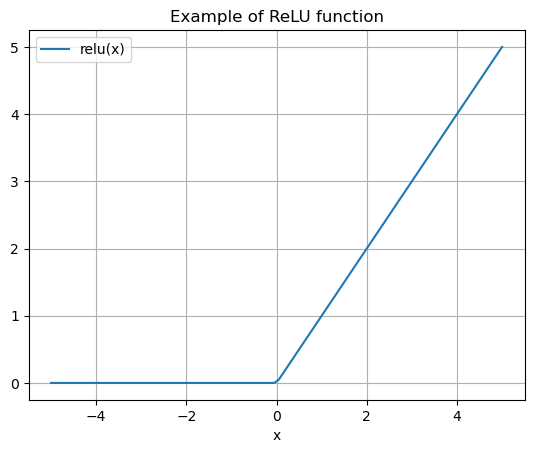

In [130]:
df_relu.plot(title='Example of ReLU function', grid=True)